In [1]:
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm  # Importa tqdm para mostrar la barra de progreso
from pprint import pprint
from bs4 import BeautifulSoup
import re
from time import sleep
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
df_reptiles = pd.read_csv("Reptiles_air.csv")

In [3]:
df_reptiles.columns

Index(['name', 'locations', 'taxonomy_kingdom', 'taxonomy_phylum',
       'taxonomy_class', 'taxonomy_order', 'taxonomy_family', 'taxonomy_genus',
       'taxonomy_scientific_name', 'characteristics_prey',
       'characteristics_name_of_young', 'characteristics_group_behavior',
       'characteristics_estimated_population_size',
       'characteristics_biggest_threat',
       'characteristics_most_distinctive_feature',
       'characteristics_other_name(s)', 'characteristics_gestation_period',
       'characteristics_habitat', 'characteristics_diet',
       'characteristics_average_litter_size', 'characteristics_lifestyle',
       'characteristics_common_name', 'characteristics_number_of_species',
       'characteristics_location', 'characteristics_slogan',
       'characteristics_group', 'characteristics_color',
       'characteristics_skin_type', 'characteristics_top_speed',
       'characteristics_lifespan', 'characteristics_weight',
       'characteristics_length', 'characteristic

In [4]:
df_reptiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 58 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   name                                       196 non-null    object 
 1   locations                                  196 non-null    object 
 2   taxonomy_kingdom                           196 non-null    object 
 3   taxonomy_phylum                            196 non-null    object 
 4   taxonomy_class                             196 non-null    object 
 5   taxonomy_order                             196 non-null    object 
 6   taxonomy_family                            196 non-null    object 
 7   taxonomy_genus                             196 non-null    object 
 8   taxonomy_scientific_name                   196 non-null    object 
 9   characteristics_prey                       196 non-null    object 
 10  characteristics_name_of_yo

In [4]:
df_reptiles["taxonomy_order"].unique()

df_reptiles['taxonomy_order'] = df_reptiles['taxonomy_order'].str.lower()

# Diccionario para ponerles a todos el mismo concepto si compete
grupos_similares = {
    'squamata': 'squamata',
    'squmata': 'squamata',
    'squamat': 'squamata',
    'reptilia order:\tsquamata': 'squamata',
}

# Agrupamos y contabilizamos correctamente
df_reptiles['taxonomy_order'] = df_reptiles['taxonomy_order'].replace(grupos_similares)


conteo = df_reptiles['taxonomy_order'].value_counts()

print(conteo)


squamata        167
testudines       20
crocodilia        7
sphenodontia      1
unknown           1
Name: taxonomy_order, dtype: int64


**1 - AGRUPACIÓN DE LOS REPTILES SEGÚN SU "TAXONOMY FAMILY" Y SU "TAXONOMY ORDER":**

* Gráfico: Gráfico de barras apiladas
* Columnas necesarias: 'Taxonomy_order', 'taxonomy_family'

- Hemos considerado interesante contabilizar cuantos reptiles de cada taxonomy family hay en cada taxonomy   order.

- Vamos a comenzar definiendo cada taxonomy order para entender mejor cómo se clasifican:

**- Sphenodontia:**
- O rincocéfalos (Rhynchocephalia) son un orden de saurópsidos (reptiles) lepidosaurios que incluye un solo género actual, Sphenodon.

**- Cocodilia:**
- Grandes reptiles predadores semiacuáticos

**- Testudines:**
- Las tortugas (Testudines) o quelonios (Chelonia)

**- Squamata:**
- Los escamosos (Squamata) son un orden de saurópsidos (reptiles) diápsidos que incluye los lagartos, camaleones, iguanas y formas afines, las serpientes y las culebrillas ciegas.

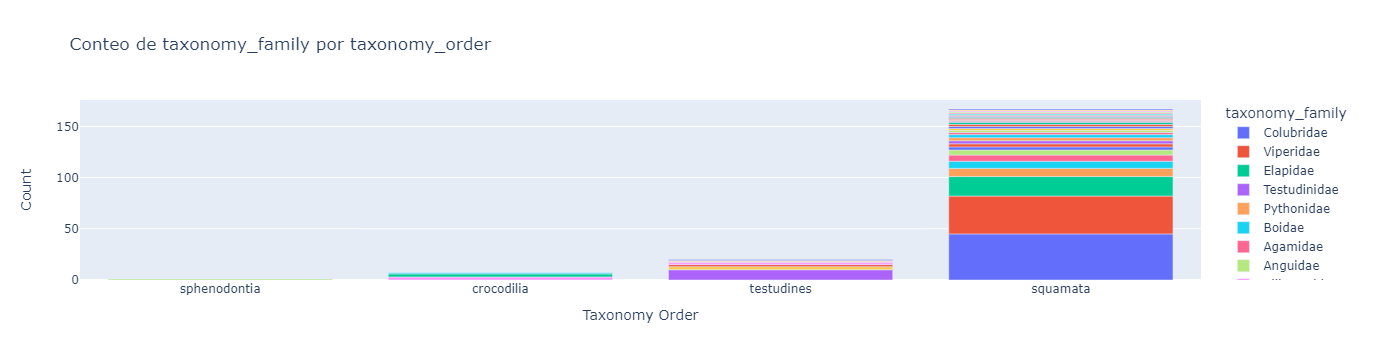

In [6]:
df_reptiles_filtrado = df_reptiles[(df_reptiles['taxonomy_order'] != 'unknown') & (df_reptiles['taxonomy_family'] != 'unknown')]

# Agrupa los datos filtrados por 'taxonomy_order' y 'taxonomy_family' y cuenta el número de ocurrencias
df_agrupado = df_reptiles_filtrado.groupby(['taxonomy_order', 'taxonomy_family']).size().reset_index(name='count')

# Ordena el DataFrame por el conteo ('count') de mayor a menor
df_agrupado = df_agrupado.sort_values(by='count', ascending=False)

# Crea el gráfico de barras apiladas
fig = px.bar(df_agrupado, x='taxonomy_order', y='count', color='taxonomy_family',
             title='Conteo de taxonomy_family por taxonomy_order',
             labels={'count': 'Count'})

# Personalización
fig.update_layout(xaxis_title='Taxonomy Order', yaxis_title='Count')
fig.update_xaxes(categoryorder='total ascending')

# Muestra el gráfico
fig.show()



**CONCLUSIÓN**

- En la orden "Squamata," las familias "Colubridae" y "Viperidae" son las más numerosas, seguidas de "Elapidae" y "Pythonidae," con varias familias menos comunes.

- En la orden "Testudines," "Testudinidae" y "Emydidae" destacan como las familias más representadas, con algunas otras en menor proporción.

- La orden "Crocodilia" incluye tres familias que abarcan caimanes y cocodrilos, y "Gavialidae" tiene una sola representación.

- La orden "Sphenodontia" cuenta con un único individuo, siendo la menos común en comparación con otras órdenes.

**2 - VAMOS A ANALIZAR LAS CARACTERÍSTICAS DEL HABITAT SEGÚN EL ORDEN TAXONÓMICO**


* Gráfico: Gráfico de nube de palabras
* Columnas necesarias: 'Taxonomy_order', 'characteristics_habitat'

In [7]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:

# Palabras de parada
nltk.download('stopwords')

# Función para limpiar y extraer palabras clave
def extract_keywords(description):
    # Tokeniza y convierte en minúscula
    words = nltk.word_tokenize(description.lower())
    
    # Filtra las palabras de parada
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Elimina signos de puntuación
    words = [word for word in words if word.isalnum()]
    
    # Devuelve una palabra clave (la primera palabra) o 'Desconocido' si está vacío
    return words[0] if words else 'Desconocido'

# Aplica la función de extracción de palabras clave a la columna
df_reptiles['characteristics_habitat_clave'] = df_reptiles['characteristics_habitat'].apply(extract_keywords)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


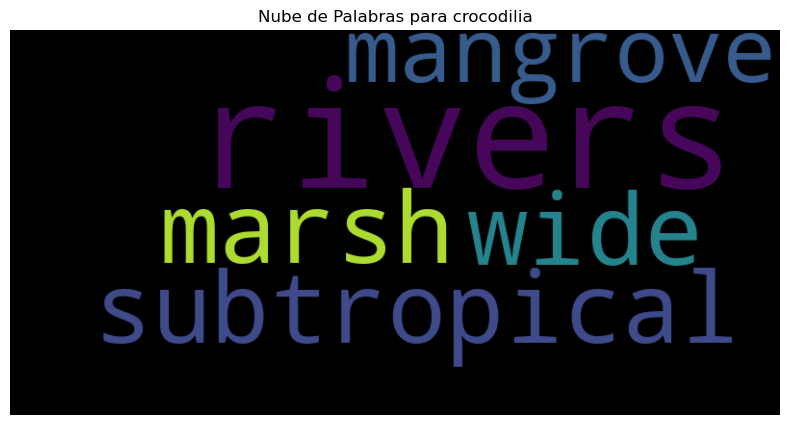

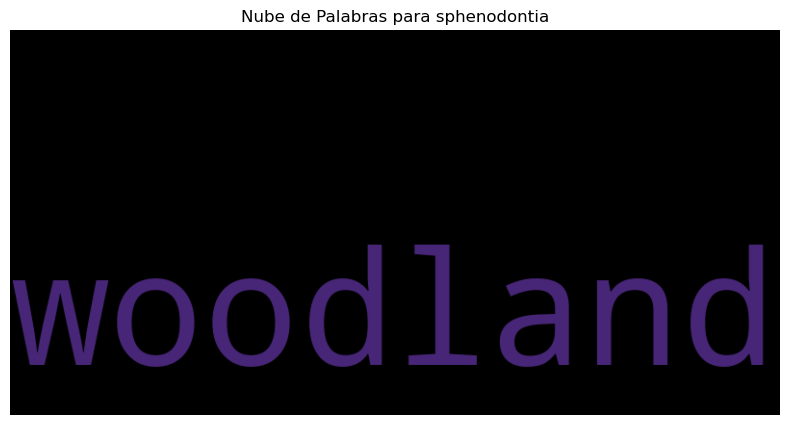

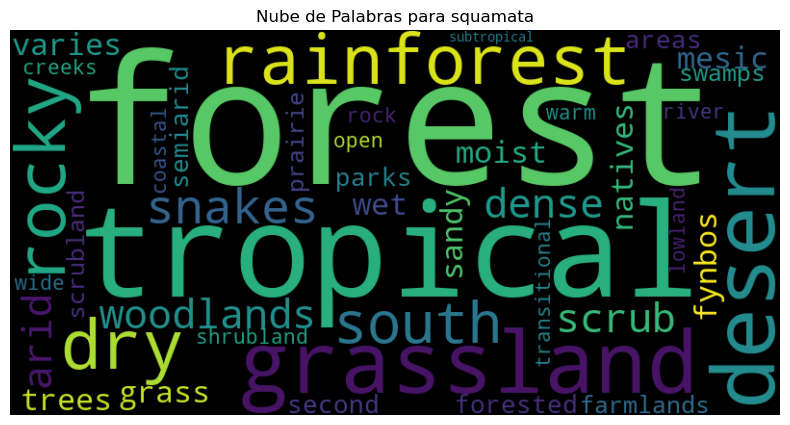

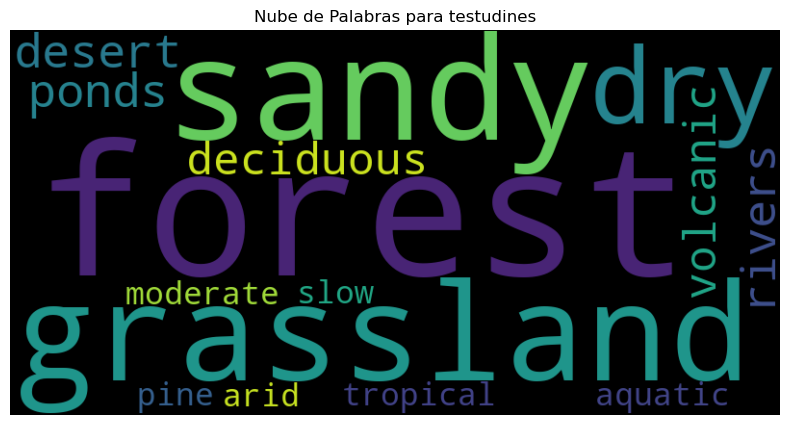

In [49]:


# Eliminar las filas que contienen "Unknown" en 'characteristics_habitat_clave'
df_reptiles = df_reptiles[df_reptiles['characteristics_habitat_clave'] != 'Unknown']

# Agrupar por 'taxonomy_order' y generar una nube de palabras para cada grupo
for taxonomy_order, group_data in df_reptiles.groupby('taxonomy_order'):
    wordcloud_data = ' '.join(group_data['characteristics_habitat_clave'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_text(wordcloud_data)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nube de Palabras para {taxonomy_order}")
    plt.show()


**CONCLUSIÓN**

**- Crocodilia:**

- La predominancia del término 'rivers' en el tamaño de las palabras sugiere que los hábitats fluviales son la característica más destacada y preponderante en la taxonomía de Crocodilia. Además, "widemarsh" y "subtropical" también se destacan, lo que sugiere la importancia de hábitats de marisma amplia y condiciones subtropicales para estas especies.

**- Sphenodontia:**

- En el análisis, observamos que la orden Sphenodontia cuenta con un único conteo, y la palabra clave 'woodland' es la única que aparece en relación a esta categoría. Esto sugiere que 'woodland' es el hábitat identificado para la única instancia de esta orden, lo que resalta su preferencia por entornos boscosos."

**- Squamata:**

- El análisis de palabras clave revela que la orden Squamata muestra una fuerte preferencia por hábitats tropicales, boscosos y de pastizales. Además, se observa una relevancia significativa de hábitats como áreas de arbustos ('woodlands'), praderas ('prairie'), selvas tropicales ('rainforest') y matorrales ('shrubland'). En un nivel más amplio, se identifican una variedad de hábitats adicionales, desde áreas de árboles hasta zonas rocosas y entornos secos o húmedos. Estos resultados destacan la adaptabilidad de la orden Squamata a diversos hábitats en su distribución

**- Testudines:**

- Testudines muestra una fuerte afinidad por hábitats forestales. En segundo lugar, se encuentran hábitats como áreas arenosas, pastizales y entornos secos, lo que refleja la adaptación a terrenos menos arbolados. En tercer lugar, se identifican hábitats que incluyen cuerpos de agua como estanques y ríos, así como regiones desérticas, tropicales y áreas de árboles caducifolios. Además, se observa una presencia moderada en entornos volcánicos y áreas con un ritmo acuático más lento.



**3 - RELACIÓN DE PESO Y ALTURA**

* Gráfico: Gráfico de dispersión
* Columnas necesarias: 'peso_en_kg', 'altura_cm'

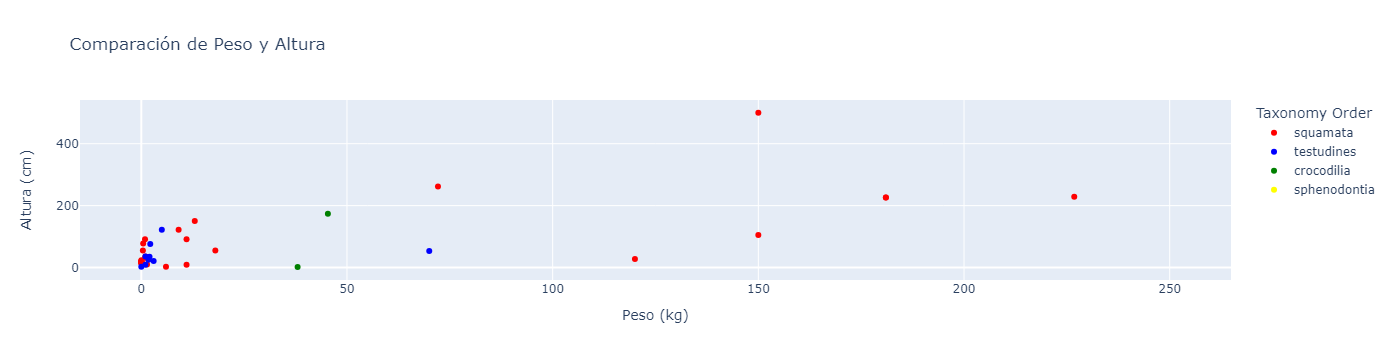

In [35]:
fig = px.scatter(df_reptiles, x='peso_en_kg', y='altura_cm', title='Comparación de Peso y Altura')

colors = {
    'squamata': 'red',  # Color para taxonomy_order 'A'
    'testudines': 'blue',  # Color para taxonomy_order 'B'
    'crocodilia': 'green',
    'sphenodontia': 'yellow'}# Color para taxonomy_order 'C'

fig = px.scatter(df_reptiles, x='peso_en_kg', y='altura_cm', color='taxonomy_order',color_discrete_map=colors, title='Comparación de Peso y Altura',
                 labels={'peso_en_kg': 'Peso (kg)', 'altura_cm': 'Altura (cm)', 'taxonomy_order': 'Taxonomy Order'},
                 hover_name='name')


fig.show()

**CONCLUSIÓN**

- "Squamata" muestra la mayor variabilidad en peso, abarcando un amplio rango de 100 a 250 kg. Entre sus miembros notables se encuentra el "Komodo Dragon," con un impresionante peso de 226.80 kg y una altura de 2.28 metros. Otro destacado es la "Arizona Black Rattlesnake," que pesa 150 kg y alcanza una altura de 5 metros.

- "Testudines" exhibe un peso más moderado, oscilando entre 1 y 4 kg, con alturas que van desde centímetros hasta poco más de un metro.

- "Crocodilia" presenta un rango de peso de 40 a 50 kg y alturas superiores a 1 metro. Destaca un caso excepcional con una altura de 2 cm y un peso de 38 kg.

- No se proporcionaron datos para la orden "Sphenodontia," por lo que no se incluye en esta comparación de peso y altura.

**4 - ANÁLISIS DE LA RELACIÓN ENTRE LA DIETA, EL PESO, LA ALTURA Y LA TAXONOMÍA**

* Gráfico: Gráfico de nube de palabras
* Columnas necesarias: 'taxonomy_order', 'peso_en_kg', 'characteristics_diet' y 'altura_cm'

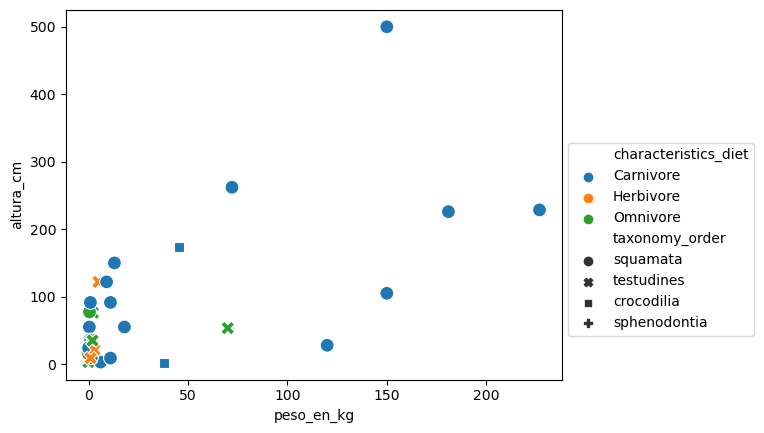

In [45]:
sns.scatterplot(
                data  = df_reptiles,
                x     = "peso_en_kg", 
                y     = "altura_cm", 
                hue   = 'characteristics_diet',
                style = 'taxonomy_order',
                s     = 100
                )
plt.legend(loc='lower center', bbox_to_anchor = (1.2,0.1))
plt.show()

**CONCLUSIÓN**

- En este análisis gráfico, hemos explorado la relación entre la dieta, el orden taxonómico, el peso y la altura de los reptiles. Los resultados revelan patrones interesantes en nuestra muestra:

- En el orden "Squamata", la mayoría de los reptiles son carnívoros, con algunas excepciones que tienen una dieta omnívora.

- En contraste, en la orden "Testudines," observamos una distribución equitativa entre dietas herbívoras y omnívoras.

- Los reptiles pertenecientes al orden "Crocodilia" se alimentan de carne.

**4 - ANÁLISIS DE LOS COLORES SEGÚN SU ORDEN TAXONÓMICO Y SU DIETA**

* Gráfico: Gráfico de barras apiladas
* Columnas necesarias: 'taxonomy_order', 'characteristics_color' -> Vamos a categorizarla

In [68]:
# Crear una función para clasificar los colores
def clasificar_color(num_colores):
    if num_colores <= 7:
        return 'unicolor'
    elif num_colores < 12:
        return 'bicolor'
    elif num_colores < 16:
        return 'tricolor'
    elif num_colores < 25:
        return 'cuatricolor'
    else:
        return 'multicolor'

# Contar el número de colores en la columna "characteristics_color"
df_reptiles['num_colores'] = df_reptiles['characteristics_color'].str.split('').apply(len)

# Aplicar la función de clasificación y crear una nueva columna "color_clasification"
df_reptiles['color_clasification'] = df_reptiles['num_colores'].apply(clasificar_color)

# Eliminar la columna temporal "num_colores" 
df_reptiles.drop('num_colores', axis=1, inplace=True)


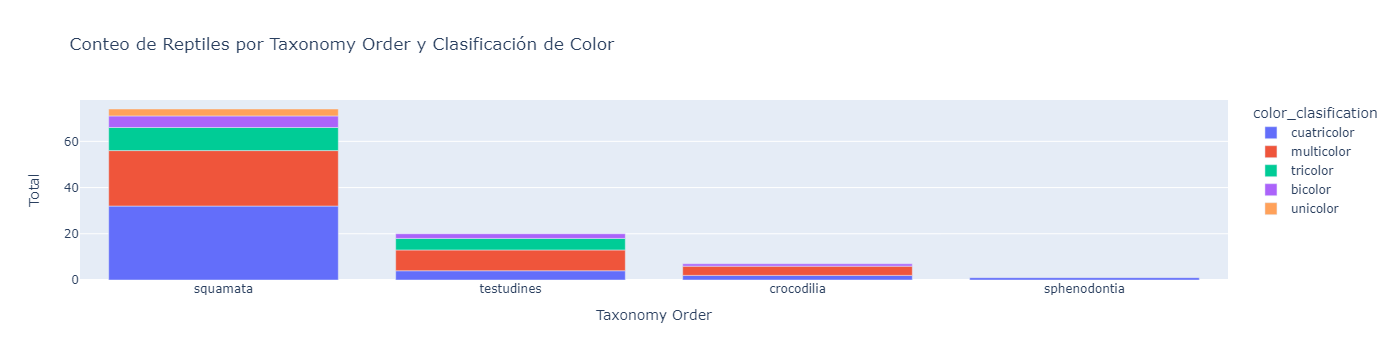

In [70]:
df_reptiles_filtrado = df_reptiles[(df_reptiles['color_clasification'] != 'unknown') & (df_reptiles['taxonomy_order'] != 'unknown')]

order = ['unicolor', 'bicolor', 'tricolor', 'cuatricolor', 'multicolor']

# Filtra el DataFrame para eliminar valores desconocidos y mantener solo las columnas necesarias
df_reptiles_filtrado = df_reptiles[(df_reptiles['color_clasification'] != 'unknown') & (df_reptiles['taxonomy_order'] != 'unknown')]

# Agrupa los datos filtrados por 'taxonomy_order' y 'color_classification' y cuenta el número de ocurrencias
df_agrupado = df_reptiles_filtrado.groupby(['taxonomy_order', 'color_clasification']).size().reset_index(name='count')

# Ordena el DataFrame según el orden deseado para las clasificaciones de color
df_agrupado['color_clasification'] = pd.Categorical(df_agrupado['color_clasification'], categories=order, ordered=True)

# Ordena el DataFrame por 'count' (total) de mayor a menor
df_agrupado = df_agrupado.sort_values(by='count', ascending=False)

# Crea el gráfico de barras apiladas
fig = px.bar(df_agrupado, x='taxonomy_order', y='count', color='color_clasification',
             title='Conteo de Reptiles por Taxonomy Order y Clasificación de Color',
             labels={'count': 'Total'})

# Personalización
fig.update_layout(xaxis_title='Taxonomy Order', yaxis_title='Total')
fig.update_xaxes(categoryorder='total descending')  # Ordenar de mayor a menor

# Muestra el gráfico
fig.show()



**CONCLUSIÓN**

- En la orden "Squamata," se observa una predominancia de reptiles cuatricolores, seguidos de multicolores, tricolores, y bicolores. La clasificación unicolor es escasa en esta orden.

- Los reptiles del orden "Testudines" presentan principalmente clasificaciones multicolores y tricolores, seguidos de cuatricolores y bicolores, con una ausencia de unicolores en esta muestra.

- En la orden "Crocodilia," se destaca la presencia de reptiles clasificados como multicolores, seguidos de cuatricolores, con una representación minoritaria de bicolores.

- La orden "Sphenodontia" muestra un único elemento en la muestra, clasificado como cuatricolor.